In [1]:
from hcmus.core import appconfig

2025-07-15 23:06:18.832 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True


In [4]:
import os
import json
import random
import cv2
import numpy as np
from PIL import Image

# Paths
train_annotations_path = '/Volumes/Cucumber/Projects/datasets/raw/sku110k/train/annotations_train.json'
train_images_dir = '/Volumes/Cucumber/Projects/datasets/raw/sku110k/train/images/'
zoom_annotations_path = '/Volumes/Cucumber/Projects/datasets/curated/sku110k-zoom/train/annotations_train.json'
zoom_images_dir = '/Volumes/Cucumber/Projects/datasets/curated/sku110k-zoom/train/images/'
zoom_factor_setting = (1.0, 5.0)
min_area_ratio = 0.3  # Minimum 30% of original area must be preserved

# Load the COCO annotations
with open(train_annotations_path, 'r') as f:
    train_annotations = json.load(f)

# Create the zoom directory if it doesn't exist
os.makedirs(zoom_images_dir, exist_ok=True)

# Function to randomly zoom and crop an image
def random_zoom_crop(image, zoom_factor, max_size=1600):
    h, w = image.shape[:2]
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)

    # Random corner selection
    corner = random.choice(['top_left', 'top_right', 'bottom_left', 'bottom_right'])
    if corner == 'top_left':
        x, y = 0, 0
    elif corner == 'top_right':
        x, y = w - new_w, 0
    elif corner == 'bottom_left':
        x, y = 0, h - new_h
    elif corner == 'bottom_right':
        x, y = w - new_w, h - new_h

    # Crop the image
    cropped_image = image[y:y+new_h, x:x+new_w]

    # Resize the image to max_size
    scale = min(max_size / cropped_image.shape[1], max_size / cropped_image.shape[0])
    resized_image = cv2.resize(cropped_image, (int(cropped_image.shape[1] * scale), int(cropped_image.shape[0] * scale)))

    return resized_image, (x, y, new_w, new_h, scale)

# Function to calculate intersection area between original bbox and crop region
def calculate_intersection_area(bbox, crop_x, crop_y, crop_w, crop_h):
    """Calculate the intersection area between bbox and crop region"""
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    # Calculate intersection bounds
    x1 = max(bbox_x, crop_x)
    y1 = max(bbox_y, crop_y)
    x2 = min(bbox_x + bbox_w, crop_x + crop_w)
    y2 = min(bbox_y + bbox_h, crop_y + crop_h)

    # If no intersection, return 0
    if x1 >= x2 or y1 >= y2:
        return 0

    return (x2 - x1) * (y2 - y1)

# Function to update bounding boxes and check area ratio
def update_bbox_with_filter(bbox, crop_info, min_ratio=0.3):
    x, y, new_w, new_h, scale = crop_info
    original_area = bbox[2] * bbox[3]

    # Calculate intersection area with crop region
    intersection_area = calculate_intersection_area(bbox, x, y, new_w, new_h)

    # Check if intersection area meets minimum ratio requirement
    if intersection_area < original_area * min_ratio:
        return None  # Filter out this bbox

    # Update bbox coordinates
    updated_bbox = [
        (bbox[0] - x) * scale,
        (bbox[1] - y) * scale,
        bbox[2] * scale,
        bbox[3] * scale
    ]

    # Additional check: ensure the updated bbox is still within reasonable bounds
    # and has meaningful dimensions after scaling
    if updated_bbox[2] < 5 or updated_bbox[3] < 5:  # Too small after scaling
        return None

    return updated_bbox

# Process each image in the train set
zoom_annotations = {'images': [], 'annotations': [], 'categories': train_annotations['categories']}
skipped_images = 0
total_boxes_before = 0
total_boxes_after = 0

for image_info in train_annotations['images']:
    image_path = os.path.join(train_images_dir, image_info['file_name'])
    image = cv2.imread(image_path)

    if image is None:
        print(f"Warning: Could not load image {image_path}")
        continue

    # Random zoom factor
    zoom_factor = random.uniform(*zoom_factor_setting)

    # Apply random zoom and crop
    zoomed_image, crop_info = random_zoom_crop(image, zoom_factor)

    # Collect valid annotations for this image
    valid_annotations = []
    image_boxes_before = 0

    for ann in train_annotations['annotations']:
        if ann['image_id'] == image_info['id']:
            image_boxes_before += 1
            updated_bbox = update_bbox_with_filter(ann['bbox'], crop_info, min_area_ratio)

            if updated_bbox is not None:
                updated_ann = ann.copy()
                updated_ann['bbox'] = updated_bbox
                # Update area as well
                updated_ann['area'] = updated_bbox[2] * updated_bbox[3]
                valid_annotations.append(updated_ann)

    # Only save the image if it has at least one valid annotation
    if valid_annotations:
        # Save the zoomed image
        zoomed_image_name = f"zoomed_{image_info['file_name']}"
        cv2.imwrite(os.path.join(zoom_images_dir, zoomed_image_name), zoomed_image)

        # Update image info
        zoomed_image_info = image_info.copy()
        zoomed_image_info['file_name'] = zoomed_image_name
        zoomed_image_info['width'] = zoomed_image.shape[1]
        zoomed_image_info['height'] = zoomed_image.shape[0]
        zoom_annotations['images'].append(zoomed_image_info)

        # Add valid annotations
        zoom_annotations['annotations'].extend(valid_annotations)

        total_boxes_before += image_boxes_before
        total_boxes_after += len(valid_annotations)
    else:
        skipped_images += 1
        print(f"Skipped image {image_info['file_name']} - no valid boxes after filtering")

# Save the new annotations
with open(zoom_annotations_path, 'w') as f:
    json.dump(zoom_annotations, f)

print(f"Processing complete!")
print(f"Total images processed: {len(train_annotations['images'])}")
print(f"Images with valid annotations: {len(zoom_annotations['images'])}")
print(f"Images skipped (no valid boxes): {skipped_images}")
print(f"Total boxes before filtering: {total_boxes_before}")
print(f"Total boxes after filtering: {total_boxes_after}")
print(f"Box retention rate: {total_boxes_after/total_boxes_before*100:.1f}%")
print(f"Zoomed images and annotations saved to {zoom_images_dir} and {zoom_annotations_path}")

Skipped image train_1009.jpg - no valid boxes after filtering
Skipped image train_105.jpg - no valid boxes after filtering
Skipped image train_1051.jpg - no valid boxes after filtering
Skipped image train_1073.jpg - no valid boxes after filtering
Skipped image train_1074.jpg - no valid boxes after filtering
Skipped image train_1086.jpg - no valid boxes after filtering
Skipped image train_1090.jpg - no valid boxes after filtering
Skipped image train_1092.jpg - no valid boxes after filtering
Skipped image train_11.jpg - no valid boxes after filtering
Skipped image train_1127.jpg - no valid boxes after filtering
Skipped image train_1131.jpg - no valid boxes after filtering
Skipped image train_114.jpg - no valid boxes after filtering
Skipped image train_1146.jpg - no valid boxes after filtering
Skipped image train_1153.jpg - no valid boxes after filtering
Skipped image train_1179.jpg - no valid boxes after filtering
Skipped image train_1191.jpg - no valid boxes after filtering
Skipped imag

Corrupt JPEG data: premature end of data segment


Skipped image train_1296.jpg - no valid boxes after filtering
Skipped image train_1317.jpg - no valid boxes after filtering
Skipped image train_1323.jpg - no valid boxes after filtering
Skipped image train_1330.jpg - no valid boxes after filtering
Skipped image train_1390.jpg - no valid boxes after filtering
Skipped image train_1395.jpg - no valid boxes after filtering
Skipped image train_1433.jpg - no valid boxes after filtering
Skipped image train_1441.jpg - no valid boxes after filtering
Skipped image train_1446.jpg - no valid boxes after filtering
Skipped image train_1450.jpg - no valid boxes after filtering
Skipped image train_1465.jpg - no valid boxes after filtering
Skipped image train_1481.jpg - no valid boxes after filtering
Skipped image train_1487.jpg - no valid boxes after filtering
Skipped image train_1494.jpg - no valid boxes after filtering
Skipped image train_1501.jpg - no valid boxes after filtering
Skipped image train_1505.jpg - no valid boxes after filtering
Skipped 

Corrupt JPEG data: bad Huffman code


Skipped image train_2378.jpg - no valid boxes after filtering
Skipped image train_2392.jpg - no valid boxes after filtering
Skipped image train_2395.jpg - no valid boxes after filtering
Skipped image train_2404.jpg - no valid boxes after filtering
Skipped image train_2411.jpg - no valid boxes after filtering
Skipped image train_2431.jpg - no valid boxes after filtering
Skipped image train_2460.jpg - no valid boxes after filtering
Skipped image train_2503.jpg - no valid boxes after filtering
Skipped image train_2516.jpg - no valid boxes after filtering
Skipped image train_2523.jpg - no valid boxes after filtering
Skipped image train_2543.jpg - no valid boxes after filtering
Skipped image train_2549.jpg - no valid boxes after filtering
Skipped image train_2556.jpg - no valid boxes after filtering
Skipped image train_2570.jpg - no valid boxes after filtering
Skipped image train_2576.jpg - no valid boxes after filtering
Skipped image train_2594.jpg - no valid boxes after filtering
Skipped 

Corrupt JPEG data: premature end of data segment


Skipped image train_2909.jpg - no valid boxes after filtering
Skipped image train_2916.jpg - no valid boxes after filtering
Skipped image train_2948.jpg - no valid boxes after filtering
Skipped image train_2954.jpg - no valid boxes after filtering
Skipped image train_2973.jpg - no valid boxes after filtering
Skipped image train_2977.jpg - no valid boxes after filtering
Skipped image train_2981.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_2992.jpg - no valid boxes after filtering
Skipped image train_2994.jpg - no valid boxes after filtering
Skipped image train_2998.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_3053.jpg - no valid boxes after filtering
Skipped image train_3093.jpg - no valid boxes after filtering
Skipped image train_3108.jpg - no valid boxes after filtering
Skipped image train_3117.jpg - no valid boxes after filtering
Skipped image train_3130.jpg - no valid boxes after filtering
Skipped image train_3172.jpg - no valid boxes after filtering
Skipped image train_3189.jpg - no valid boxes after filtering
Skipped image train_3192.jpg - no valid boxes after filtering
Skipped image train_3195.jpg - no valid boxes after filtering
Skipped image train_3197.jpg - no valid boxes after filtering
Skipped image train_3198.jpg - no valid boxes after filtering
Skipped image train_320.jpg - no valid boxes after filtering
Skipped image train_3207.jpg - no valid boxes after filtering
Skipped image train_3209.jpg - no valid boxes after filtering
Skipped image train_3220.jpg - no valid boxes after filtering
Skipped image train_3238.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_3245.jpg - no valid boxes after filtering
Skipped image train_3253.jpg - no valid boxes after filtering
Skipped image train_3268.jpg - no valid boxes after filtering
Skipped image train_327.jpg - no valid boxes after filtering
Skipped image train_3271.jpg - no valid boxes after filtering
Skipped image train_3282.jpg - no valid boxes after filtering
Skipped image train_3293.jpg - no valid boxes after filtering
Skipped image train_3294.jpg - no valid boxes after filtering
Skipped image train_3295.jpg - no valid boxes after filtering
Skipped image train_3304.jpg - no valid boxes after filtering
Skipped image train_3308.jpg - no valid boxes after filtering
Skipped image train_3312.jpg - no valid boxes after filtering
Skipped image train_3359.jpg - no valid boxes after filtering
Skipped image train_3368.jpg - no valid boxes after filtering
Skipped image train_3375.jpg - no valid boxes after filtering
Skipped image train_338.jpg - no valid boxes after filtering
Skipped im

Premature end of JPEG file


Skipped image train_3431.jpg - no valid boxes after filtering
Skipped image train_3433.jpg - no valid boxes after filtering
Skipped image train_3434.jpg - no valid boxes after filtering
Skipped image train_3458.jpg - no valid boxes after filtering
Skipped image train_3464.jpg - no valid boxes after filtering
Skipped image train_3485.jpg - no valid boxes after filtering
Skipped image train_3486.jpg - no valid boxes after filtering
Skipped image train_3493.jpg - no valid boxes after filtering
Skipped image train_3503.jpg - no valid boxes after filtering
Skipped image train_3516.jpg - no valid boxes after filtering
Skipped image train_3524.jpg - no valid boxes after filtering
Skipped image train_3529.jpg - no valid boxes after filtering
Skipped image train_3534.jpg - no valid boxes after filtering


Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


Skipped image train_357.jpg - no valid boxes after filtering
Skipped image train_3590.jpg - no valid boxes after filtering
Skipped image train_3602.jpg - no valid boxes after filtering
Skipped image train_3607.jpg - no valid boxes after filtering
Skipped image train_3629.jpg - no valid boxes after filtering
Skipped image train_3641.jpg - no valid boxes after filtering
Skipped image train_3662.jpg - no valid boxes after filtering
Skipped image train_3677.jpg - no valid boxes after filtering
Skipped image train_3683.jpg - no valid boxes after filtering
Skipped image train_3690.jpg - no valid boxes after filtering
Skipped image train_370.jpg - no valid boxes after filtering
Skipped image train_3705.jpg - no valid boxes after filtering
Skipped image train_3717.jpg - no valid boxes after filtering
Skipped image train_3765.jpg - no valid boxes after filtering
Skipped image train_3770.jpg - no valid boxes after filtering
Skipped image train_3772.jpg - no valid boxes after filtering
Skipped im

Corrupt JPEG data: 12658 extraneous bytes before marker 0xd2


Skipped image train_380.jpg - no valid boxes after filtering
Skipped image train_3806.jpg - no valid boxes after filtering
Skipped image train_3824.jpg - no valid boxes after filtering


Corrupt JPEG data: 102 extraneous bytes before marker 0xd9


Skipped image train_3843.jpg - no valid boxes after filtering
Skipped image train_3875.jpg - no valid boxes after filtering
Skipped image train_3894.jpg - no valid boxes after filtering
Skipped image train_3918.jpg - no valid boxes after filtering
Skipped image train_3919.jpg - no valid boxes after filtering
Skipped image train_3928.jpg - no valid boxes after filtering
Skipped image train_393.jpg - no valid boxes after filtering
Skipped image train_3972.jpg - no valid boxes after filtering
Skipped image train_3983.jpg - no valid boxes after filtering
Skipped image train_3996.jpg - no valid boxes after filtering
Skipped image train_4011.jpg - no valid boxes after filtering
Skipped image train_4023.jpg - no valid boxes after filtering
Skipped image train_4043.jpg - no valid boxes after filtering
Skipped image train_4045.jpg - no valid boxes after filtering
Skipped image train_4049.jpg - no valid boxes after filtering
Skipped image train_406.jpg - no valid boxes after filtering
Skipped im

Premature end of JPEG file


Skipped image train_4223.jpg - no valid boxes after filtering
Skipped image train_4244.jpg - no valid boxes after filtering
Skipped image train_427.jpg - no valid boxes after filtering
Skipped image train_4274.jpg - no valid boxes after filtering
Skipped image train_4281.jpg - no valid boxes after filtering
Skipped image train_4288.jpg - no valid boxes after filtering
Skipped image train_4290.jpg - no valid boxes after filtering
Skipped image train_4302.jpg - no valid boxes after filtering
Skipped image train_4314.jpg - no valid boxes after filtering
Skipped image train_4346.jpg - no valid boxes after filtering
Skipped image train_4357.jpg - no valid boxes after filtering
Skipped image train_4393.jpg - no valid boxes after filtering
Skipped image train_4427.jpg - no valid boxes after filtering
Skipped image train_4431.jpg - no valid boxes after filtering
Skipped image train_4439.jpg - no valid boxes after filtering
Skipped image train_444.jpg - no valid boxes after filtering
Skipped im

Corrupt JPEG data: premature end of data segment


Skipped image train_5008.jpg - no valid boxes after filtering
Skipped image train_5015.jpg - no valid boxes after filtering
Skipped image train_504.jpg - no valid boxes after filtering
Skipped image train_5040.jpg - no valid boxes after filtering
Skipped image train_5055.jpg - no valid boxes after filtering
Skipped image train_5056.jpg - no valid boxes after filtering
Skipped image train_5086.jpg - no valid boxes after filtering
Skipped image train_51.jpg - no valid boxes after filtering
Skipped image train_5105.jpg - no valid boxes after filtering
Skipped image train_5112.jpg - no valid boxes after filtering
Skipped image train_5129.jpg - no valid boxes after filtering


Corrupt JPEG data: 562 extraneous bytes before marker 0xd9


Skipped image train_5139.jpg - no valid boxes after filtering


Corrupt JPEG data: 572 extraneous bytes before marker 0xd9


Skipped image train_515.jpg - no valid boxes after filtering
Skipped image train_5156.jpg - no valid boxes after filtering
Skipped image train_5172.jpg - no valid boxes after filtering
Skipped image train_5186.jpg - no valid boxes after filtering
Skipped image train_5200.jpg - no valid boxes after filtering
Skipped image train_5203.jpg - no valid boxes after filtering
Skipped image train_5250.jpg - no valid boxes after filtering
Skipped image train_5268.jpg - no valid boxes after filtering
Skipped image train_5333.jpg - no valid boxes after filtering
Skipped image train_5344.jpg - no valid boxes after filtering
Skipped image train_5345.jpg - no valid boxes after filtering
Skipped image train_535.jpg - no valid boxes after filtering
Skipped image train_5362.jpg - no valid boxes after filtering
Skipped image train_5390.jpg - no valid boxes after filtering
Skipped image train_5424.jpg - no valid boxes after filtering
Skipped image train_5430.jpg - no valid boxes after filtering
Skipped im

Corrupt JPEG data: 41 extraneous bytes before marker 0xd9


Skipped image train_5780.jpg - no valid boxes after filtering
Skipped image train_5784.jpg - no valid boxes after filtering
Skipped image train_5787.jpg - no valid boxes after filtering
Skipped image train_5800.jpg - no valid boxes after filtering
Skipped image train_5803.jpg - no valid boxes after filtering
Skipped image train_5807.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_5842.jpg - no valid boxes after filtering
Skipped image train_5860.jpg - no valid boxes after filtering
Skipped image train_5873.jpg - no valid boxes after filtering
Skipped image train_5884.jpg - no valid boxes after filtering
Skipped image train_5889.jpg - no valid boxes after filtering
Skipped image train_5895.jpg - no valid boxes after filtering
Skipped image train_5932.jpg - no valid boxes after filtering
Skipped image train_5942.jpg - no valid boxes after filtering
Skipped image train_5978.jpg - no valid boxes after filtering
Skipped image train_5994.jpg - no valid boxes after filtering
Skipped image train_5997.jpg - no valid boxes after filtering
Skipped image train_6004.jpg - no valid boxes after filtering
Skipped image train_603.jpg - no valid boxes after filtering
Skipped image train_6046.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_6087.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_6090.jpg - no valid boxes after filtering
Skipped image train_6115.jpg - no valid boxes after filtering
Skipped image train_6125.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_6161.jpg - no valid boxes after filtering
Skipped image train_6167.jpg - no valid boxes after filtering
Skipped image train_623.jpg - no valid boxes after filtering
Skipped image train_6249.jpg - no valid boxes after filtering
Skipped image train_6293.jpg - no valid boxes after filtering
Skipped image train_6295.jpg - no valid boxes after filtering
Skipped image train_635.jpg - no valid boxes after filtering
Skipped image train_6351.jpg - no valid boxes after filtering
Skipped image train_6353.jpg - no valid boxes after filtering
Skipped image train_6382.jpg - no valid boxes after filtering
Skipped image train_6388.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_6421.jpg - no valid boxes after filtering
Skipped image train_6449.jpg - no valid boxes after filtering
Skipped image train_6468.jpg - no valid boxes after filtering
Skipped image train_6469.jpg - no valid boxes after filtering
Skipped image train_647.jpg - no valid boxes after filtering
Skipped image train_6474.jpg - no valid boxes after filtering
Skipped image train_6477.jpg - no valid boxes after filtering
Skipped image train_6486.jpg - no valid boxes after filtering
Skipped image train_6491.jpg - no valid boxes after filtering
Skipped image train_6498.jpg - no valid boxes after filtering
Skipped image train_651.jpg - no valid boxes after filtering
Skipped image train_6512.jpg - no valid boxes after filtering
Skipped image train_6554.jpg - no valid boxes after filtering
Skipped image train_6563.jpg - no valid boxes after filtering
Skipped image train_6613.jpg - no valid boxes after filtering
Skipped image train_663.jpg - no valid boxes after filtering
Skipped ima

Corrupt JPEG data: 405 extraneous bytes before marker 0xd9


Skipped image train_6723.jpg - no valid boxes after filtering
Skipped image train_6729.jpg - no valid boxes after filtering
Skipped image train_6733.jpg - no valid boxes after filtering
Skipped image train_6737.jpg - no valid boxes after filtering
Skipped image train_6766.jpg - no valid boxes after filtering
Skipped image train_677.jpg - no valid boxes after filtering
Skipped image train_6771.jpg - no valid boxes after filtering
Skipped image train_6773.jpg - no valid boxes after filtering
Skipped image train_6774.jpg - no valid boxes after filtering
Skipped image train_6775.jpg - no valid boxes after filtering
Skipped image train_6786.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_6788.jpg - no valid boxes after filtering
Skipped image train_6891.jpg - no valid boxes after filtering
Skipped image train_6894.jpg - no valid boxes after filtering
Skipped image train_69.jpg - no valid boxes after filtering
Skipped image train_692.jpg - no valid boxes after filtering
Skipped image train_6925.jpg - no valid boxes after filtering
Skipped image train_693.jpg - no valid boxes after filtering
Skipped image train_6931.jpg - no valid boxes after filtering
Skipped image train_6938.jpg - no valid boxes after filtering
Skipped image train_701.jpg - no valid boxes after filtering
Skipped image train_7013.jpg - no valid boxes after filtering
Skipped image train_702.jpg - no valid boxes after filtering
Skipped image train_704.jpg - no valid boxes after filtering
Skipped image train_7055.jpg - no valid boxes after filtering
Skipped image train_7064.jpg - no valid boxes after filtering
Skipped image train_7075.jpg - no valid boxes after filtering
Skipped image t

Corrupt JPEG data: 96 extraneous bytes before marker 0xd9


Skipped image train_74.jpg - no valid boxes after filtering
Skipped image train_7410.jpg - no valid boxes after filtering
Skipped image train_7427.jpg - no valid boxes after filtering
Skipped image train_7430.jpg - no valid boxes after filtering
Skipped image train_7446.jpg - no valid boxes after filtering
Skipped image train_7447.jpg - no valid boxes after filtering
Skipped image train_7463.jpg - no valid boxes after filtering
Skipped image train_7479.jpg - no valid boxes after filtering
Skipped image train_7483.jpg - no valid boxes after filtering
Skipped image train_7491.jpg - no valid boxes after filtering
Skipped image train_7497.jpg - no valid boxes after filtering
Skipped image train_75.jpg - no valid boxes after filtering
Skipped image train_751.jpg - no valid boxes after filtering
Skipped image train_7512.jpg - no valid boxes after filtering
Skipped image train_7525.jpg - no valid boxes after filtering
Skipped image train_7545.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_7578.jpg - no valid boxes after filtering
Skipped image train_7592.jpg - no valid boxes after filtering
Skipped image train_7599.jpg - no valid boxes after filtering
Skipped image train_7609.jpg - no valid boxes after filtering
Skipped image train_7610.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_7645.jpg - no valid boxes after filtering
Skipped image train_7667.jpg - no valid boxes after filtering
Skipped image train_7673.jpg - no valid boxes after filtering
Skipped image train_7734.jpg - no valid boxes after filtering
Skipped image train_7737.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_7775.jpg - no valid boxes after filtering
Skipped image train_7784.jpg - no valid boxes after filtering
Skipped image train_7790.jpg - no valid boxes after filtering
Skipped image train_7806.jpg - no valid boxes after filtering
Skipped image train_7832.jpg - no valid boxes after filtering
Skipped image train_7837.jpg - no valid boxes after filtering
Skipped image train_7860.jpg - no valid boxes after filtering
Skipped image train_7864.jpg - no valid boxes after filtering
Skipped image train_7867.jpg - no valid boxes after filtering
Skipped image train_7870.jpg - no valid boxes after filtering
Skipped image train_7881.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_7887.jpg - no valid boxes after filtering


Corrupt JPEG data: 4086 extraneous bytes before marker 0xd9


Skipped image train_7891.jpg - no valid boxes after filtering
Skipped image train_7913.jpg - no valid boxes after filtering
Skipped image train_7922.jpg - no valid boxes after filtering
Skipped image train_7926.jpg - no valid boxes after filtering
Skipped image train_7952.jpg - no valid boxes after filtering
Skipped image train_7966.jpg - no valid boxes after filtering
Skipped image train_7967.jpg - no valid boxes after filtering


Corrupt JPEG data: 270 extraneous bytes before marker 0xd9


Skipped image train_8046.jpg - no valid boxes after filtering
Skipped image train_806.jpg - no valid boxes after filtering
Skipped image train_8073.jpg - no valid boxes after filtering
Skipped image train_8093.jpg - no valid boxes after filtering
Skipped image train_8102.jpg - no valid boxes after filtering
Skipped image train_8119.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_8155.jpg - no valid boxes after filtering
Skipped image train_8177.jpg - no valid boxes after filtering
Skipped image train_8192.jpg - no valid boxes after filtering
Skipped image train_820.jpg - no valid boxes after filtering
Skipped image train_8222.jpg - no valid boxes after filtering
Skipped image train_826.jpg - no valid boxes after filtering
Skipped image train_85.jpg - no valid boxes after filtering
Skipped image train_857.jpg - no valid boxes after filtering
Skipped image train_872.jpg - no valid boxes after filtering


Premature end of JPEG file


Skipped image train_890.jpg - no valid boxes after filtering
Skipped image train_90.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_907.jpg - no valid boxes after filtering


Premature end of JPEG file


Skipped image train_926.jpg - no valid boxes after filtering
Skipped image train_940.jpg - no valid boxes after filtering
Skipped image train_942.jpg - no valid boxes after filtering
Skipped image train_945.jpg - no valid boxes after filtering
Skipped image train_950.jpg - no valid boxes after filtering
Skipped image train_998.jpg - no valid boxes after filtering
Processing complete!
Total images processed: 8219
Images with valid annotations: 7722
Images skipped (no valid boxes): 497
Total boxes before filtering: 1136317
Total boxes after filtering: 243727
Box retention rate: 21.4%
Zoomed images and annotations saved to /Volumes/Cucumber/Projects/datasets/curated/sku110k-zoom/train/images/ and /Volumes/Cucumber/Projects/datasets/curated/sku110k-zoom/train/annotations_train.json


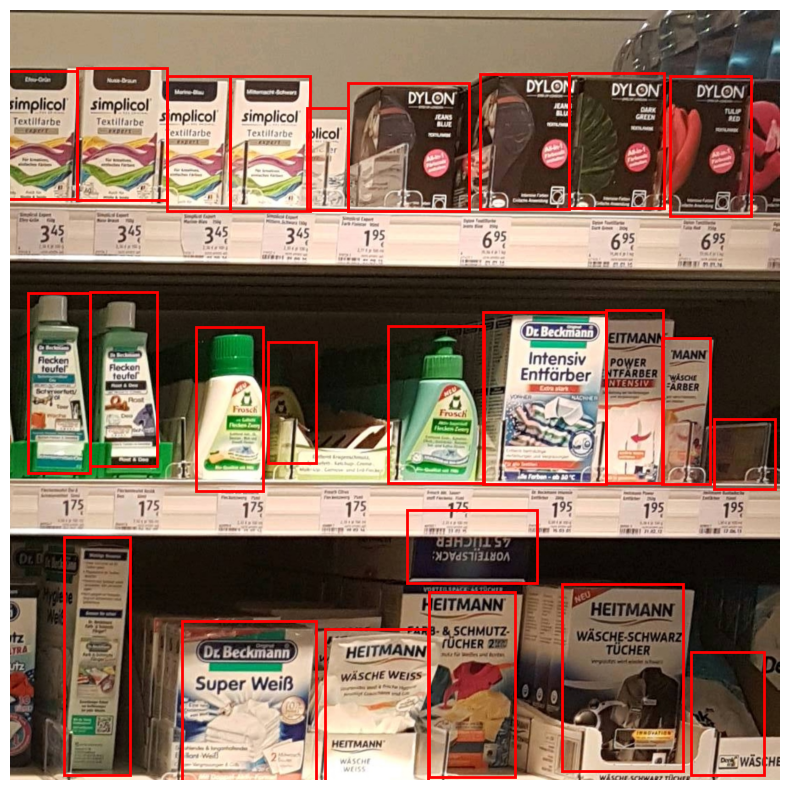

In [9]:
from PIL import Image
from hcmus.utils import viz_utils
# annotations_path = "/Volumes/Cucumber/Projects/datasets/sku110k/train/annotations_train.json"
# images_path = "/Volumes/Cucumber/Projects/datasets/sku110k/train/images"
annotations_path = '/Volumes/Cucumber/Projects/datasets/curated/sku110k-zoom/train/annotations_train.json'
images_path = '/Volumes/Cucumber/Projects/datasets/curated/sku110k-zoom/train/images/'
annotations = json.load(open(annotations_path))

idx = 0
image_idx = annotations.get("images")[idx]
image_path = images_path + "/" + image_idx.get("file_name")
image = Image.open(image_path)
boxes = []
for a in annotations.get("annotations"):
    if a.get("image_id") == image_idx.get("id"):
        bbox = a.get("bbox")
        bbox[2] = bbox[0] + bbox[2]
        bbox[3] = bbox[1] + bbox[3]
        boxes.append(a.get("bbox"))
viz_utils.draw_boxes(image, boxes)